<a href="https://colab.research.google.com/github/Leonop/narrativesBERT/blob/main/berttopic_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERTopic on Large Datasets**

Due to the modularity of BERTopic, it can also be used on large datasets (> 1_000_000) if we change some of the internal algorithms such that they can scale a bit better.

To do so, this example uses Google Colab Pro (T4 with 25GB of VRAM and 26GB of System RAM) and cuML to enable GPU-accelerated machine learning.

First, we will need to install some packages: 

     Conda virtualenv: cuda_env
     Cuda toolkit == 11.8
     Cuml cu12 == 23.04

In [1]:
# %%capture
# !pip install git+https://github.com/MaartenGr/BERTopic.git@master

# !pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

# !pip install safetensors
# !pip install datasets
# !pip install datashader
# !pip install adjustText
# !pip install sentence-transformers==2.2.2

Sometimes, it might happen that you get the `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968` error, if so make sure to run the following code:

```python
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

**(Optional)** We can mount a personal Google Drive such that we can save the resulting embeddings and models that you create. Although it is not necessary, if you created embeddings and then run into memory errors, it is generally nice to have the embeddings saved somewhere without needing to recalculate them.

In [2]:
# from google.colab import drive
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# drive.mount('/content/drive')

# Define the path to your CSV file
# folder_path = '/content/drive/My Drive/Research/TAD_LDA_optimized'
# file_path = '/content/drive/My Drive/Research/TAD_LDA_optimized/cc_firm_level.csv'
# use relative path to find the dataset
current_path = os.getcwd()
file_path = os.path.join(current_path, 'data', 'earnings_calls_20231017.csv')

In [3]:
import os
print(os.path.exists(file_path))
print(file_path)

True
/home/zc_research/narrativesBERT/data/earnings_calls_20231017.csv


# **Data**

To show how BERTopic can be used with large data, we are going to load in some Wikipedia texts. Cohere has fortunately created a dataset split by paragraphs, which allows us to stay within token limit sizes.

For this example, we load in 1 million texts from Wikipedia and see if we can extract topics from them.

In [4]:
# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at path {file_path} does not exist.")

# Define the file path and the number of rows to read as a subsample
nrows = 10000000  # Adjust this number to read a subsample

# Use chunksize to limit rows number per iteration
meta = pd.DataFrame()
try:
    chunk_reader = pd.read_csv(file_path, chunksize=10000, nrows=nrows)
except OSError as e:
    print(f"Error reading the file: {e}")
    raise
# Wrap the chunk reader with tqdm to track progress
for chunk in tqdm(chunk_reader, total=nrows//10000):
    chunk["transcriptcreationdate_utc"] = pd.to_datetime(chunk["transcriptcreationdate_utc"])
    chunk["publish_year"] = pd.DatetimeIndex(chunk['transcriptcreationdate_utc']).year
    chunk["publish_month"] = pd.DatetimeIndex(chunk['transcriptcreationdate_utc']).month

    # Select papers published later than 2013
    filtered_chunk = chunk[chunk["year"] <= 2015]
    filtered_chunk = filtered_chunk.reset_index()
    meta = pd.concat([meta, filtered_chunk], ignore_index=True)

meta = meta.drop(columns=['Unnamed: 0'])
docs = [str(row['componenttextpreview']) for _, row in meta.iterrows() if row["index"] != 1000000]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


# **Basic Example**

Now that we have our data, we can start with a basic example. This example shows the minimum steps necessary for training a BERTopic model on large datasets. Do note though that memory errors are still possible when tweaking parameters. After this section, some tips and tricks will be mentioned to demonstrate how we can further reduce memory or be more efficient with our training process.

## Embeddings

Next, we are going to pre-calculate the embeddings as input for our BERTopic model. The reason for doing this is that this input step can take quite some time to compute. If we pre-calculate them and save the resulting embeddings, we can skip over this step when we are iterating over our model.

In [5]:
from sentence_transformers import SentenceTransformer

# Create embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(docs, show_progress_bar=True)

/home/zc_research/miniconda3/envs/cuda_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zc_research/miniconda3/envs/cuda_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 3125/3125 [00:48<00:00, 64.60it/s] 


We can save the resulting embeddings as follows:

In [6]:
import numpy as np
with open(os.path.join(current_path, "model", 'embeddings.pny'), 'wb') as f:
    np.save(f, embeddings)

and then load the embeddings as follows:

In [7]:
embeddings = np.load(os.path.join(current_path, "model", 'embeddings.pny'))

## Prepare Vocab

Before we can start with training our model, there is still something that we can do to reduce the necessary memory. We can prepare our vocabulary beforehand such that the tokenizer does not need to do the calculations itself.

Below, we are essentially creating a vocabulary of words in our dataset and parsing them such that they need to appear at least 15 times in our data.

With sufficient RAM, we could skip over this step but I have found this often helps in reducing the necessary RAM.

**Note**: If you are using a custom CountVectorizer, then it is advised to use that instead of the default CountVectorizer to build the tokenizer.

In [8]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Extract vocab to be used in BERTopic
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))
vocab = [word for word, frequency in vocab.items() if frequency >= 15]; len(vocab)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:01<00:00, 99942.10it/s]


7085

## Train BERTopic

Finally, we can train our BERTopic model. We select the same sentence-transformer model as we did before. Moreover, we select cuML's HDBSCAN and UMAP models. These are GPU-accelerated versions of HDBSCAN and UMAP and allow us to speed training on such a large dataset.

In [9]:
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from bertopic import BERTopic

# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=False, min_cluster_size=20, verbose=True)
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings)

/home/zc_research/miniconda3/envs/cuda_env/lib/python3.8/site-packages/cupy/_environment.py:438: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
huggingface/tokenizers: The current process just got forked, after parallelism has already been used.

[D] [02:12:04.741702] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:108 n_neighbors=50
[D] [02:12:04.742609] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:130 Calling knn graph run
[D] [02:12:10.448476] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:136 Done. Calling fuzzy simplicial set
[D] [02:12:10.478510] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:317 Smooth kNN Distances
[D] [02:12:10.479354] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:319 sigmas = [ 0.0971107, 0.164562, 0.0172164, 0.121797, 0.0851686, 0.0828736, 0.0533733, 0.0990305, 0.216195, 0.0351129, 0.0319281, 0.0368819, 0.226013, 0.246484, 0.115815, 0.138291, 0.0800657, 0.0471574, 0.0419739, 0.0379359, 0.176864, 0.139635, 0.00015122, 0.104547, 0.223075 ]

[D] [02:12:10.479422] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:321 rhos = [ 0.206209, 0.203148, 0.443732, 0.283265, 0.650343, 0.496461, 0.785514, 0.77786, 0.52097, 0.813636, 0.714757, 0.801814, 0

2024-09-15 02:12:23,215 - BERTopic - Dimensionality - Completed ✓
2024-09-15 02:12:23,218 - BERTopic - Cluster - Start clustering the reduced embeddings


[D] [02:12:23.093930] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:382 Smoothing KNN distances
[D] [02:12:23.102707] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:414 Executing fuzzy simplicial set
[D] [02:12:23.108619] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:443 Performing L1 normalization
[D] [02:12:23.129771] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:479 n_epochs=30
[D] [02:12:23.150231] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:502 Computing # of epochs for training each sample
[D] [02:12:23.151818] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:509 Performing optimization


2024-09-15 02:12:35,746 - BERTopic - Cluster - Completed ✓
2024-09-15 02:12:35,763 - BERTopic - Representation - Extracting topics from clusters using representation models.
/home/zc_research/miniconda3/envs/cuda_env/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df) + 1)
2024-09-15 02:12:37,310 - BERTopic - Representation - Completed ✓


and that is it! We can inspect the topics as follows:

In [10]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,62222,-1_think_just_going_yes,"[think, just, going, yes, year, ve, business, ...","[Okay. That makes sense. I missed that part, a..."
1,0,1412,0_handset_mobile_filters_content,"[handset, mobile, filters, content, wireless, ...","[Yes, James, it's hard to say, to handicap it ..."
2,1,1396,1_margin_gross_margins_mix,"[margin, gross, margins, mix, operating, impro...","[Good. I was wondering, if you could talk a li..."
3,2,1336,2_drilling_pit_grade_drill,"[drilling, pit, grade, drill, wells, mining, z...","[What is the inventory, are we talking about f..."
4,3,1186,3_instructions_operator_comes_line,"[instructions, operator, comes, line, question...",[[Operator Instructions] And our first questio...
...,...,...,...,...,...
283,282,20,282_comes_question_win_missed,"[comes, question, win, missed, queue, line, ah...",[Your next question comes from Rajeev Lalwani ...
284,283,20,283_shareholder_shareholders_value_investor,"[shareholder, shareholders, value, investor, s...","[Well, look. I mean, I think we are all here i..."
285,284,20,284_comes_line_question_analyst,"[comes, line, question, analyst, session, fina...",[Our next question comes from the line of Arvi...
286,285,20,285_coming_fronts_written_clients,"[coming, fronts, written, clients, rental, sto...",[Our next question is coming from Toshiya Hari...


Lastly, it would be advised to save the model as follows:

In [11]:
topic_model.save(
    path=os.path.join(current_path, "model"),
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model="sentence-transformers/all-MiniLM-L6-v2"
)

# **Advanced Tips & Tricks**

There are a number of advanced tips and tricks that you can use to make it a bit easier and more flexible to train your model at large datasets.

## UMAP

Just like we pre-computed the embeddings, we can pre-reduce the dimensionality of the embeddings with cuML's UMAP and use those.

This saves quite a bit of time since we need to reduce embeddings everytime we run BERTopic.

**NOTE**: Saving those embeddings, as we did before, is generally advised.

In [12]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

[D] [02:12:38.335070] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:108 n_neighbors=15
[D] [02:12:38.336595] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:130 Calling knn graph run
[D] [02:12:43.101932] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:136 Done. Calling fuzzy simplicial set
[D] [02:12:43.105278] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:317 Smooth kNN Distances
[D] [02:12:43.105475] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:319 sigmas = [ 0.0904188, 0.205878, 0.0129794, 0.113297, 0.0934887, 0.068994, 0.0668864, 0.110341, 0.23957, 0.0283287, 0.0176885, 0.0390818, 0.315425, 0.348137, 0.0748749, 0.148735, 0.0822387, 0.0407248, 0.0398816, 0.0353878, 0.216743, 0.139149, 5.9097e-05, 0.0847344, 0.293608 ]

[D] [02:12:43.105529] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:321 rhos = [ 0.206209, 0.203148, 0.443732, 0.283265, 0.650343, 0.496461, 0.785514, 0.77786, 0.52097, 0.813636, 0.714757, 0.801814, 0.

Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [13]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings_2d = umap_model.fit_transform(embeddings)

[D] [02:12:45.183554] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:108 n_neighbors=15
[D] [02:12:45.184766] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:130 Calling knn graph run
[D] [02:12:49.781089] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:136 Done. Calling fuzzy simplicial set
[D] [02:12:49.784026] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:317 Smooth kNN Distances
[D] [02:12:49.784279] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:319 sigmas = [ 0.0904188, 0.205878, 0.0129794, 0.113297, 0.0934887, 0.068994, 0.0668864, 0.110341, 0.23957, 0.0283287, 0.0176885, 0.0390818, 0.315425, 0.348137, 0.0748749, 0.148735, 0.0822387, 0.0407248, 0.0398816, 0.0353878, 0.216743, 0.139149, 5.9097e-05, 0.0847344, 0.293608 ]

[D] [02:12:49.784329] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:321 rhos = [ 0.206209, 0.203148, 0.443732, 0.283265, 0.650343, 0.496461, 0.785514, 0.77786, 0.52097, 0.813636, 0.714757, 0.801814, 0.

## HDBSCAN

We can even pre-compute the clusters with HDBSCAN and feed them to BERTopic to perform [manual topic modeling](https://maartengr.github.io/BERTopic/getting_started/manual/manual.html). Manual topic modeling with BERTopic means that if we already have labels of topics, we can use those to label them using a variety of [representation models](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html).

BERTopic can still perform inference since inference is done on topic embeddings that are created during `fit`.

In [14]:
from cuml.cluster import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [15]:
from cuml.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")
representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

2024-09-15 02:13:01,250 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-15 02:13:01,251 - BERTopic - Dimensionality - Completed ✓
2024-09-15 02:13:01,253 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-15 02:13:01,268 - BERTopic - Cluster - Completed ✓
2024-09-15 02:13:01,284 - BERTopic - Representation - Extracting topics from clusters using representation models.
/home/zc_research/miniconda3/envs/cuda_env/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df) + 1)
2024-09-15 02:13:07,371 - BERTopic - Representation - Completed ✓


In [16]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,47492,-1_revenue_business_growth_quarter,"[revenue, business, growth, quarter, sales, ca...","[That's great. And just last, a data point. Yo..."
1,0,2284,0_aircraft_airlines_aviation_airline,"[aircraft, airlines, aviation, airline, airpla...",[I'd say it comes back to flight hours again. ...
2,1,2103,1_pit_underground_pits_mining,"[pit, underground, pits, mining, drilling, ore...","[Okay. Switching over now to Kittila, similar ..."
3,2,2091,2_smartphones_smartphone_mobile_phones,"[smartphones, smartphone, mobile, phones, devi...","[Yes, James, it's hard to say, to handicap it ..."
4,3,1649,3_desktops_desktop_processors_processor,"[desktops, desktop, processors, processor, not...","[Thanks, Rory. And since you mentioned the des..."
...,...,...,...,...,...
364,363,31,363_vascular_sales_profitability_business,"[vascular, sales, profitability, business, suc...",[Okay. Let me ask a specific question on your ...
365,364,30,364_lead_times_dates_time,"[lead, times, dates, time, suppliers, standard...","[Lead times for orders you mean?, Okay. And ju..."
366,365,30,365_cost_efficiency_profitability_industries,"[cost, efficiency, profitability, industries, ...","[Scott the price on the cost side, it's actual..."
367,366,30,366_earnings_earn_growth_incremental,"[earnings, earn, growth, incremental, guidance...","[So I guess, just to kind of dig into the guid..."


## Visualize Documents

In [17]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [18]:
df.head()

,x,y,Topic,Length
0,9.118196,0.120914,170,253
2,0.093273,6.805730,347,253
5,2.145023,0.394524,330,255
7,1.233488,-1.573044,6,208
14,4.738583,5.860449,10,20


In [19]:
mean_df.head()

,Topic,x,y,Length
0,0,-2.192268,-3.168675,228.154991
1,1,-3.290673,2.889638,206.980980
104,2,5.050761,1.682604,233.166428
202,3,4.448702,0.023492,229.231656
268,4,0.969439,1.452437,221.593420


ValueError: 0        #808000
2        #ffd8b1
5        #e6194b
7        #46f0f0
14       #008080
          ...   
99990    #800000
99991    #9a6324
99993    #aaffc3
99994    #9a6324
99995    #9a6324
Name: Topic, Length: 48420, dtype: object is not a valid value for color

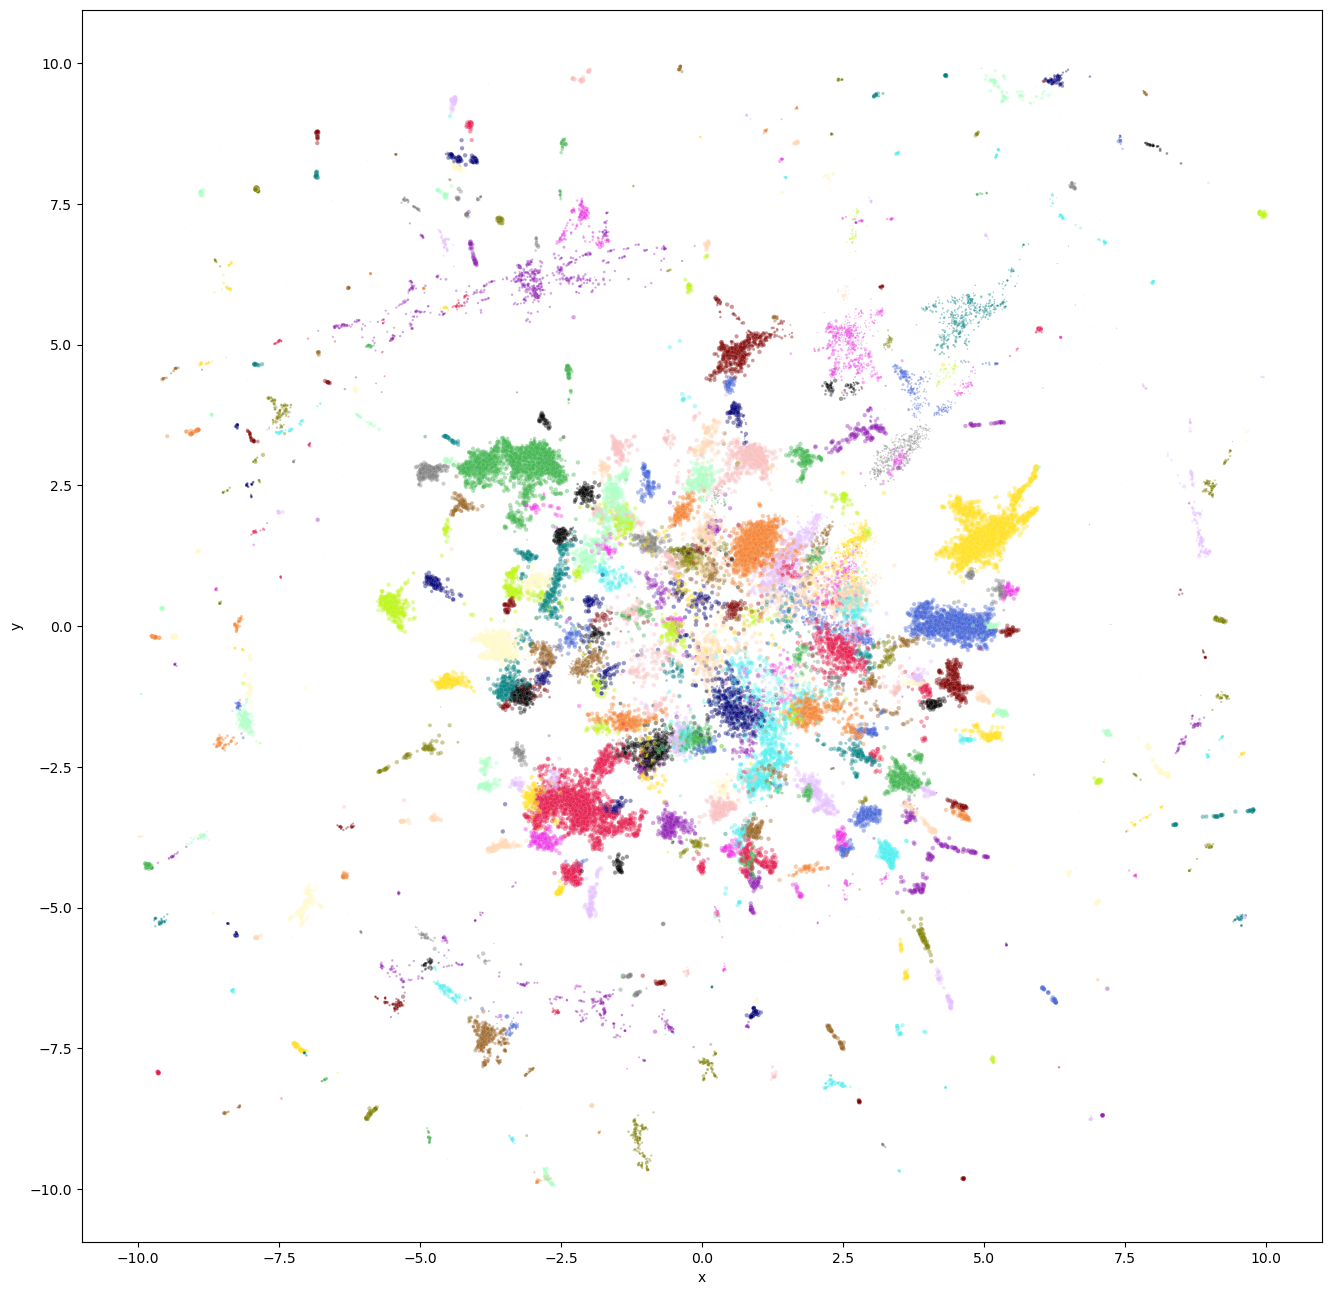

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors


fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
# plt.savefig("visualization2.png", dpi=600)

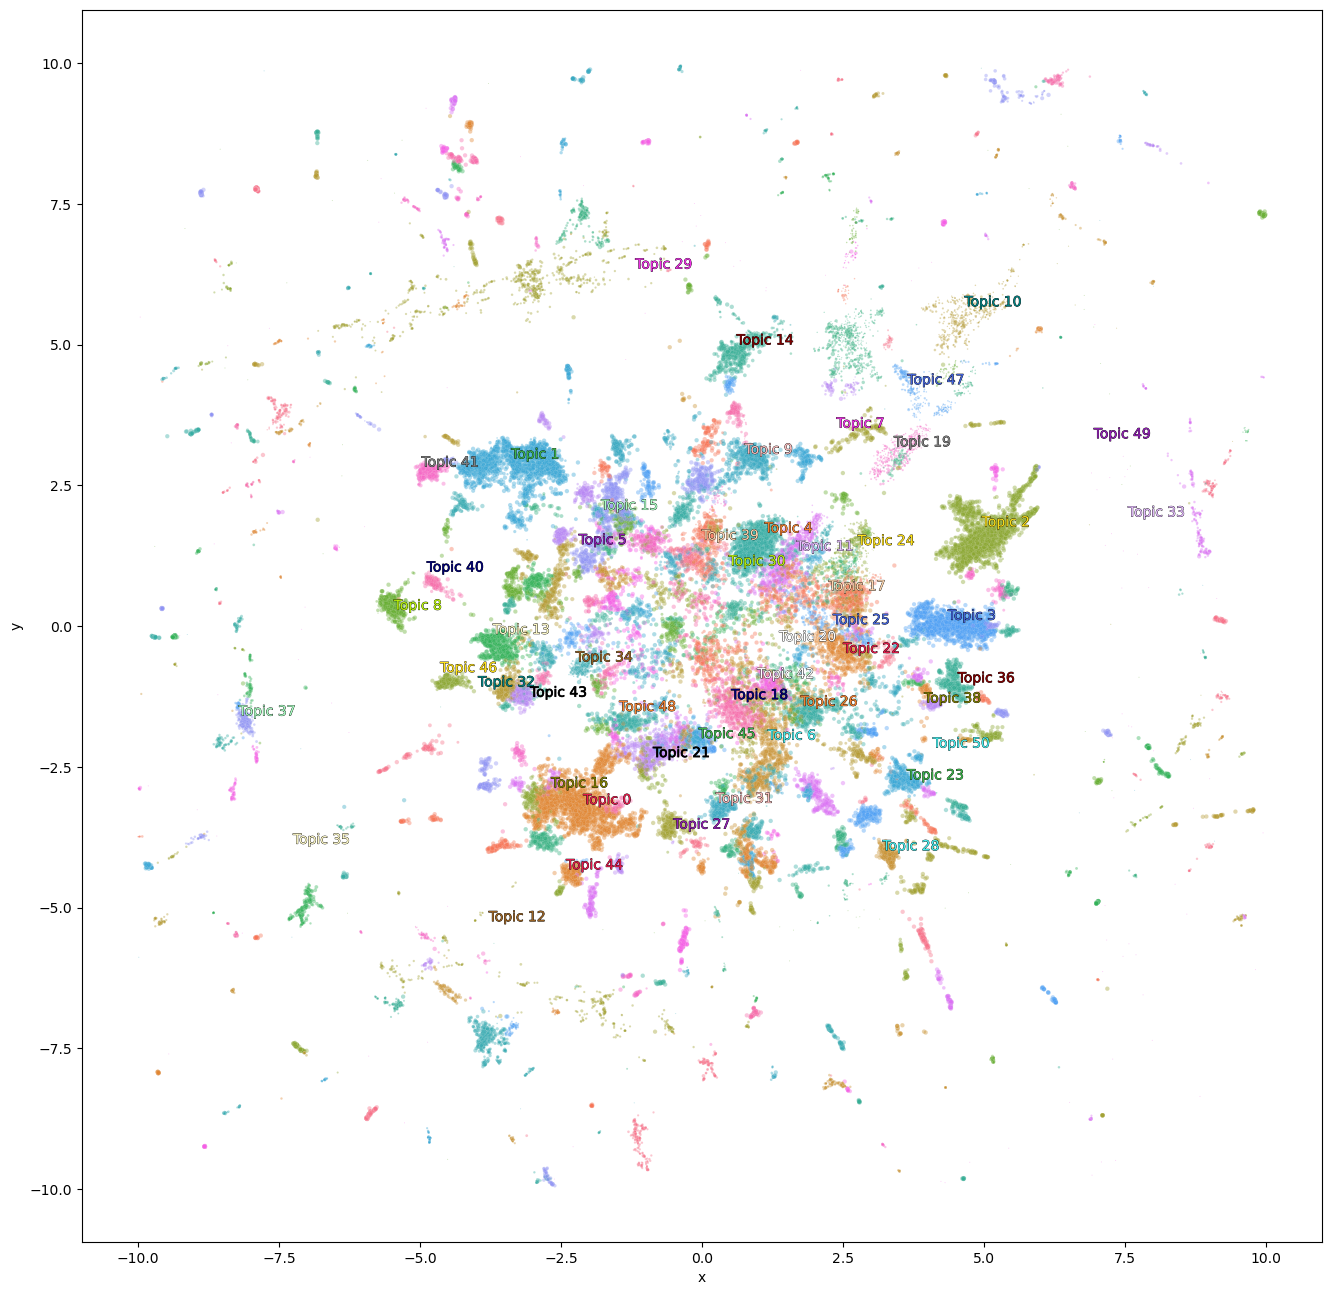

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

# Reset index to avoid MultiIndex issue
df = df.reset_index(drop=True)

# Convert 'Topic' to string to ensure proper mapping
df['Topic'] = df['Topic'].astype(str)

# Now map the colors to the 'Topic' column
df['color'] = df['Topic'].map(lambda topic: color_key.get(topic, '#000000'))  # Default to black if not found

# Create the plot
fig, ax = plt.subplots(figsize=(16, 16))

# Use 'color' directly for coloring the scatter plot
# sns.scatterplot(data=df, x='x', y='y', ax=ax, hue='color', alpha=0.4, s=10, size="Length", legend=False)
sns.scatterplot(data=df, x='x', y='y', ax=ax, hue='color', alpha=0.4, s=10, sizes=(0.4, 10), size="Length", legend=False)

# Annotate top 50 topics from mean_df
texts, xs, ys = [], [], []
for _, row in mean_df.iterrows():
    topic = row["Topic"]
    name = f"Topic {int(topic)}"

    if int(topic) <= 50:
        xs.append(row["x"])
        ys.append(row["y"])
        texts.append(ax.text(row["x"], row["y"], name, size=10, ha="center", 
                             color=color_key.get(str(int(topic)), '#000000'),
                             path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Ensure lengths of xs, ys, and texts are the same before adjusting
assert len(xs) == len(ys) == len(texts), "xs, ys, and texts must have the same length"

# Adjust annotations to avoid overlap
adjust_text(texts, x=xs, y=ys, time_lim=2, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))

plt.show()
# Uncomment to save the figure
# plt.savefig("visualization2.png", dpi=600)


In [ ]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

# Step 1: Load data and train BERTopic
docs = fetch_20newsgroups(subset='all')['data']
topic_model = BERTopic(verbose=True)
topics, _ = topic_model.fit_transform(docs)

# Step 2: Get the top words for each topic
topic_words = topic_model.get_topics()

# Prepare topic words for coherence calculation
topic_word_list = [[word for word, _ in words] for _, words in topic_words.items()]

# Step 3: Calculate the coherence score
# You can use different coherence measures: 'c_v', 'u_mass', 'c_uci', or 'c_npmi'
# 'c_v' is commonly used for topic models
coherence_model = CoherenceModel(
    topics=topic_word_list, 
    texts=[doc.split() for doc in docs],  # Tokenized documents
    dictionary=gensim.corpora.Dictionary([doc.split() for doc in docs]),
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")


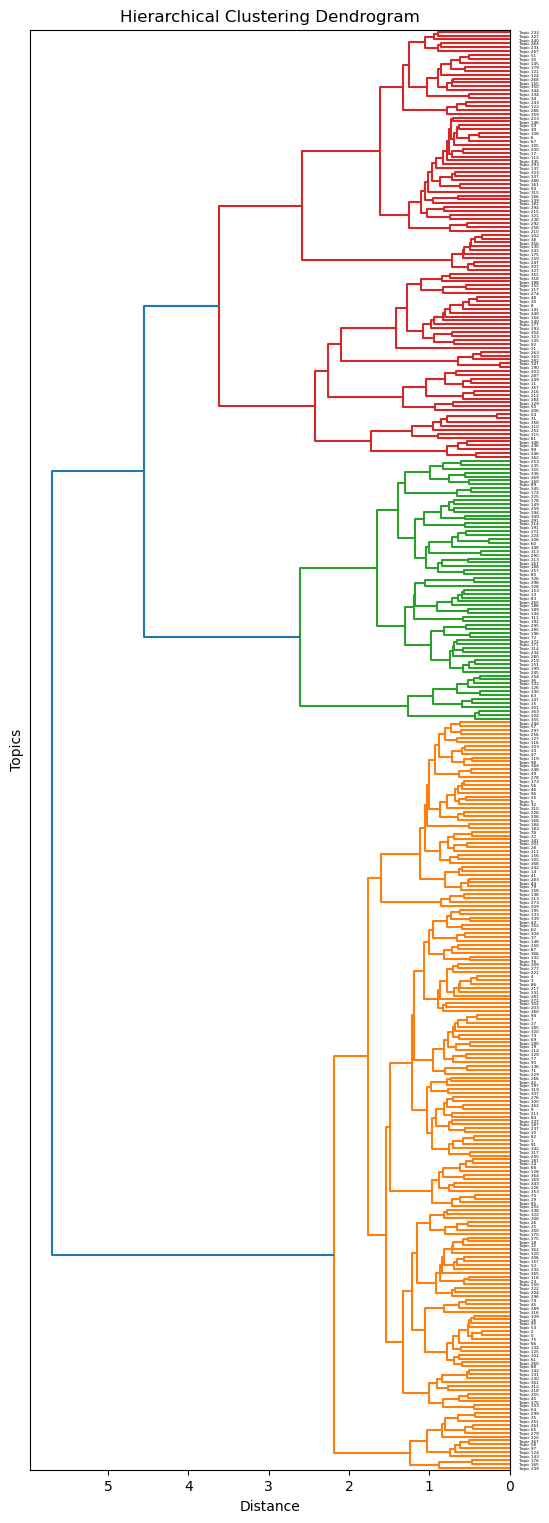

In [24]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np


# Load some sample data
# docs = [str(row['componenttextpreview']) for _, row in meta.iterrows() if row["index"] != 1000000]

# # Step 1: Load and fit BERTopic model
# topic_model = BERTopic(verbose=True)
# topics, probabilities = topic_model.fit_transform(docs)

# Step 2: Get topic embeddings to perform hierarchical clustering
embeddings = topic_model.topic_embeddings_

# Step 3: Perform Hierarchical Agglomerative Clustering using linkage
Z = linkage(embeddings, method='ward')

# Step 4: Plot the dendrogram
fig, ax = plt.subplots(figsize=(8, 16))  # Adjust size as needed

# Customize the dendrogram
dendro = dendrogram(
    Z,
    orientation='left',  # To get the layout similar to your provided image
    labels=[f'Topic {i}' for i in range(len(embeddings))],  # Adjust labels accordingly
    leaf_font_size=3,  # Adjust label size
    color_threshold=0.7 * np.max(Z[:, 2]),  # Set color threshold
)
# Adjust spacing around the figure for better clarity
plt.subplots_adjust(left=0.35, right=0.95, top=0.95, bottom=0.05)  # Adjust for better text spacing

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Distance")
plt.ylabel("Topics")
plt.grid(False)  # Disable grid for a clean look
plt.show()



In [25]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

# Step 1: Load data and train BERTopic
docs = [str(row['componenttextpreview']) for _, row in meta.iterrows() if row["index"] != 1000000]
topic_model = BERTopic(verbose=True)
topics, _ = topic_model.fit_transform(docs)

# Step 2: Get the top words for each topic
topic_words = topic_model.get_topics()

# Prepare topic words for coherence calculation
topic_word_list = [[word for word, _ in words] for _, words in topic_words.items()]

# Step 3: Calculate the coherence score
# You can use different coherence measures: 'c_v', 'u_mass', 'c_uci', or 'c_npmi'
# 'c_v' is commonly used for topic models
coherence_model = CoherenceModel(
    topics=topic_word_list, 
    texts=[doc.split() for doc in docs],  # Tokenized documents
    dictionary=gensim.corpora.Dictionary([doc.split() for doc in docs]),
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")


ModuleNotFoundError: No module named 'gensim'